In [2]:
#https://github.com/pomber/covid19
print('Initializing São Paulo\'s analysis!')
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

Initializing São Paulo's analysis!


In [3]:
df = pd.read_csv('../data/brazil_corona19_data.csv')
df['date'] = df['date'].astype('datetime64[ns]')

today = df.date.max().date()
tomorrow = today + datetime.timedelta(days=1)
yesterday = today - datetime.timedelta(days=1)
qtdeMonitored = 5

df = df[(df['state']=='SP') & (df['place_type']=='city') & (df['city']!='Importados/Indefinidos')]

df.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,city_ibge_code,...,var_death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand,avg7_cases,avg7_deaths,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand
210756,2020-06-13,SP,Álvaro de Carvalho,city,2,2,37,False,5227,3501400,...,0.0,0.383,0.383,0.0,0.0,0,0,100.0,0.0,0.0
210757,2020-06-14,SP,Álvaro de Carvalho,city,2,2,38,False,5227,3501400,...,0.0,0.383,0.383,0.0,0.0,0,0,100.0,0.0,0.0
210758,2020-06-15,SP,Álvaro de Carvalho,city,2,2,39,False,5227,3501400,...,0.0,0.383,0.383,0.0,0.0,0,0,100.0,0.0,0.0
210759,2020-06-16,SP,Álvaro de Carvalho,city,2,2,40,False,5227,3501400,...,0.0,0.383,0.383,0.0,0.0,0,0,100.0,0.0,0.0
210760,2020-06-17,SP,Álvaro de Carvalho,city,2,2,41,True,5227,3501400,...,0.0,0.383,0.383,0.0,0.0,0,0,100.0,0.0,0.0


In [4]:
city_geo = json.load(open('../data/saoPaulo-cidades.json'))
df_mapa = df[df['is_last']==True].copy()
cities = df_mapa.city.unique()

for cidade in city_geo['features']:
    latLon =  cidade['properties']['centroide']
    codarea = int(cidade['properties']['codarea'])
    df_mapa.loc[df_mapa['city_ibge_code']==codarea,'lat'] = latLon[1]
    df_mapa.loc[df_mapa['city_ibge_code']==codarea,'long'] = latLon[0]

df_mapa.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,city_ibge_code,...,deaths_thousand,case_day_thousand,death_day_thousand,avg7_cases,avg7_deaths,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand,lat,long
210580,2020-06-17,SP,Águas de Santa Bárbara,city,5,0,41,True,6075,3500550,...,0.000,0.0,0.0,0,0,0.00,0.047,0.0,-22.857687,-49.260822
210649,2020-06-17,SP,Águas de São Pedro,city,3,0,69,True,3451,3500600,...,0.000,0.0,0.0,0,0,0.00,0.000,0.0,-22.600756,-47.875962
210669,2020-06-17,SP,Álvares Florence,city,2,0,20,True,3679,3501202,...,0.000,0.0,0.0,0,0,0.00,0.039,0.0,-20.289188,-49.920387
210720,2020-06-17,SP,Álvares Machado,city,18,1,51,True,24915,3501301,...,0.040,0.0,0.0,0,0,5.65,0.006,0.0,-22.131993,-51.514752
210760,2020-06-17,SP,Álvaro de Carvalho,city,2,2,41,True,5227,3501400,...,0.383,0.0,0.0,0,0,100.00,0.000,0.0,-22.085925,-49.733223


In [5]:
state_geo = json.load(open('../data/saoPaulo-cidades.json'))
m = folium.Map(location=[-22.60, -48.44], zoom_start=7)
df_mapa.city_ibge_code = df_mapa.city_ibge_code.astype('str')

folium.Choropleth(
    geo_data=state_geo,
    name='Mortes por mil habitantes',
    data=df_mapa,
    columns=['city_ibge_code','avg7_death_day_thousand'],
    key_on='feature.properties.codarea',
    highlight=True,
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color = 'white',
    nan_fill_opacity = 0.1,
    legend_name= 'mortes por mil habitades'
).add_to(m)

for city in cities:
    dados = df_mapa[(df_mapa['city']==city)]# & (df['date']==str(today))]
    if dados.empty:
        print('cidade vazia:', city)
        continue
    detalhes = '<center><b>'+dados.city.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', mortes/1k hab.: ' + str(dados.deaths_thousand.values[0].round(3))
    
    folium.CircleMarker(
        location=[dados.lat,dados.long],
        radius=2,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='#ffff',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/saoPauloMapDeaths.html')
m

In [6]:
m = folium.Map(location=[-22.60, -48.44], zoom_start=7)
df_mapa.city_ibge_code = df_mapa.city_ibge_code.astype('str')

folium.Choropleth(
    geo_data=state_geo,
    name='Contaminações por 100 mil habitantes',
    data=df_mapa,
    columns=['city_ibge_code', 'avg7_case_day_thousand'],
    key_on='feature.properties.codarea',
    fill_color='PuRd',#'YlGn',
    #     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color = 'white',
    nan_fill_opacity = 0.1,
    legend_name='casos por mil habitantes'
).add_to(m)

for city in cities:
    dados = df_mapa[(df_mapa['city']==city)]# & (df['date']==str(today))]
    if dados.empty:
        print('cidade vazia:', city)
        continue
    detalhes = '<center><b>'+dados.city.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', casos/mil hab.: ' + str(dados.cases_thousand.values[0].round(3))
    
    folium.CircleMarker(
        location=[dados.lat,dados.long],
        radius=2,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='#ffff',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/saoPauloMapCases.html')
m

In [7]:
# #https://www.mankier.com/1/wkhtmltoimage#--width
# import imgkit
# print('Gerando imagens dos mapas de São Paulo')
# options = {
#     'format': 'png',
# #     'crop-h': '3',
# #     'crop-w': '3',
# #     'crop-x': '3',
# #     'crop-y': '3',
#     'width':'300',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')}
#     ],
# }
# imgkit.from_file('../analysis/maps/saoPauloMapDeathsContainer.html', '../analysis/maps/saoPauloMapDeaths.png', options=options)
# imgkit.from_file('../analysis/maps/saoPauloMapCasesContainer.html', '../analysis/maps/saoPauloMapCases.png', options=options)

----------------------------
### São Paulo - Analysis and monitoring

In [8]:
#week variation
lastWeek = today - datetime.timedelta(days=7)
saoPauloCities = 645

#contaminated cities
lastWeekCities = len(df.loc[df['is_last']==True, 'city'].unique())
lastWeekPercCities = int(lastWeekCities / saoPauloCities * 100)
todayCities = len(df.city.unique())
todayPercCities = int((todayCities / saoPauloCities * 100))
varCities = int((todayCities / lastWeekCities - 1) *100)
diffCities = todayCities - lastWeekCities

# cases and deaths
lastWeekCases = df.loc[df['date']==str(lastWeek), 'cases'].sum()
lastWeekDeaths = df.loc[df['date']==str(lastWeek), 'deaths'].sum()
todayCases = df.loc[df['is_last']==True, 'cases'].sum()
todayDeaths = df.loc[df['is_last']==True, 'deaths'].sum()
varCases = int((todayCases / lastWeekCases - 1) *100)
varDeaths = int((todayDeaths / lastWeekDeaths - 1) *100)
diffCases = todayCases - lastWeekCases
diffDeaths = todayDeaths - lastWeekDeaths

#### Top deadliest cities  + Santa Gertrudes + Lucelia + Rio Claro + outras

In [9]:
cols = ['city', 'date', 'day', 'population','case_day', 'cases', 'death_day', 'deaths', 'cases_thousand', 'deaths_thousand', 'perc_death']
addedCities = ['Santa Gertrudes', 'Rio Claro','Cordeirópolis', 'Limeira','Lucélia','Adamantina']

df_top_deaths = df[df['date']==str(today)].sort_values('deaths_thousand', ascending = False)

df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(qtdeMonitored).append(df_top_deaths[df_top_deaths['city'].isin(addedCities)][cols])

df_top_deaths

,city,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,Gastão Vidigal,2020-06-17,42,4808,0,34,0,7,7.072,1.456,20.59
2,Dolcinópolis,2020-06-17,26,2115,0,5,0,2,2.364,0.946,40.00
3,Uru,2020-06-17,43,1165,0,3,0,1,2.575,0.858,33.33
4,Torre de Pedra,2020-06-17,43,2412,0,6,0,2,2.488,0.829,33.33
5,Nova Castilho,2020-06-17,12,1267,0,1,0,1,0.789,0.789,100.00
58,Lucélia,2020-06-17,56,21747,0,33,0,5,1.517,0.230,15.15
125,Cordeirópolis,2020-06-17,55,24528,0,87,0,3,3.547,0.122,3.45
159,Rio Claro,2020-06-17,83,206424,0,242,0,19,1.172,0.092,7.85
168,Adamantina,2020-06-17,73,35068,0,46,0,3,1.312,0.086,6.52
189,Santa Gertrudes,2020-06-17,63,26898,0,24,0,2,0.892,0.074,8.33


#### Top most transmissible countries + Santa Gertrude + Lucélia + Adamantina + Rio Claro + Cordeirópolis + Limeira - São Paulo

In [10]:
df_top_cases = df[(df['date']==str(today)) & (df['population']>10000)].sort_values('cases_thousand', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(qtdeMonitored+1).append(df_top_cases[df_top_cases['city'].isin(addedCities)][cols])

df_top_cases

,city,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,Santos,2020-06-17,80,433311,0,6534,0,233,15.079,0.538,3.57
2,Cubatão,2020-06-17,69,130705,0,1179,0,55,9.020,0.421,4.66
3,Lençóis Paulista,2020-06-17,79,68432,0,564,0,12,8.242,0.175,2.13
4,São Paulo,2020-06-17,105,12252023,0,97676,0,5819,7.972,0.475,5.96
5,Guarujá,2020-06-17,79,320459,0,2436,0,92,7.602,0.287,3.78
6,Pariquera-Açu,2020-06-17,75,19648,0,145,0,5,7.380,0.254,3.45
40,Cordeirópolis,2020-06-17,55,24528,0,87,0,3,3.547,0.122,3.45
139,Lucélia,2020-06-17,56,21747,0,33,0,5,1.517,0.230,15.15
168,Adamantina,2020-06-17,73,35068,0,46,0,3,1.312,0.086,6.52
169,Limeira,2020-06-17,78,306114,0,401,0,21,1.310,0.069,5.24


#### Cities of São Paulo to be analised

#### Cases and deaths 

In [11]:
#inform the countries you want to analise
monitoredCities = df_top_cases['city'].head(qtdeMonitored+1).to_numpy()
# monitoredCities = df[(df['date']==str(today)) & (df['population']>10000)].sort_values('cases_thousand', ascending = False).head(qtdeMonitored+1).city.to_numpy()
# monitoredCities = np.delete(monitoredCities,np.where([monitoredCities == 'São Paulo'] or [monitoredCities == 'total geral']))
# monitoredCities = np.append(monitoredCities,[addedCity])

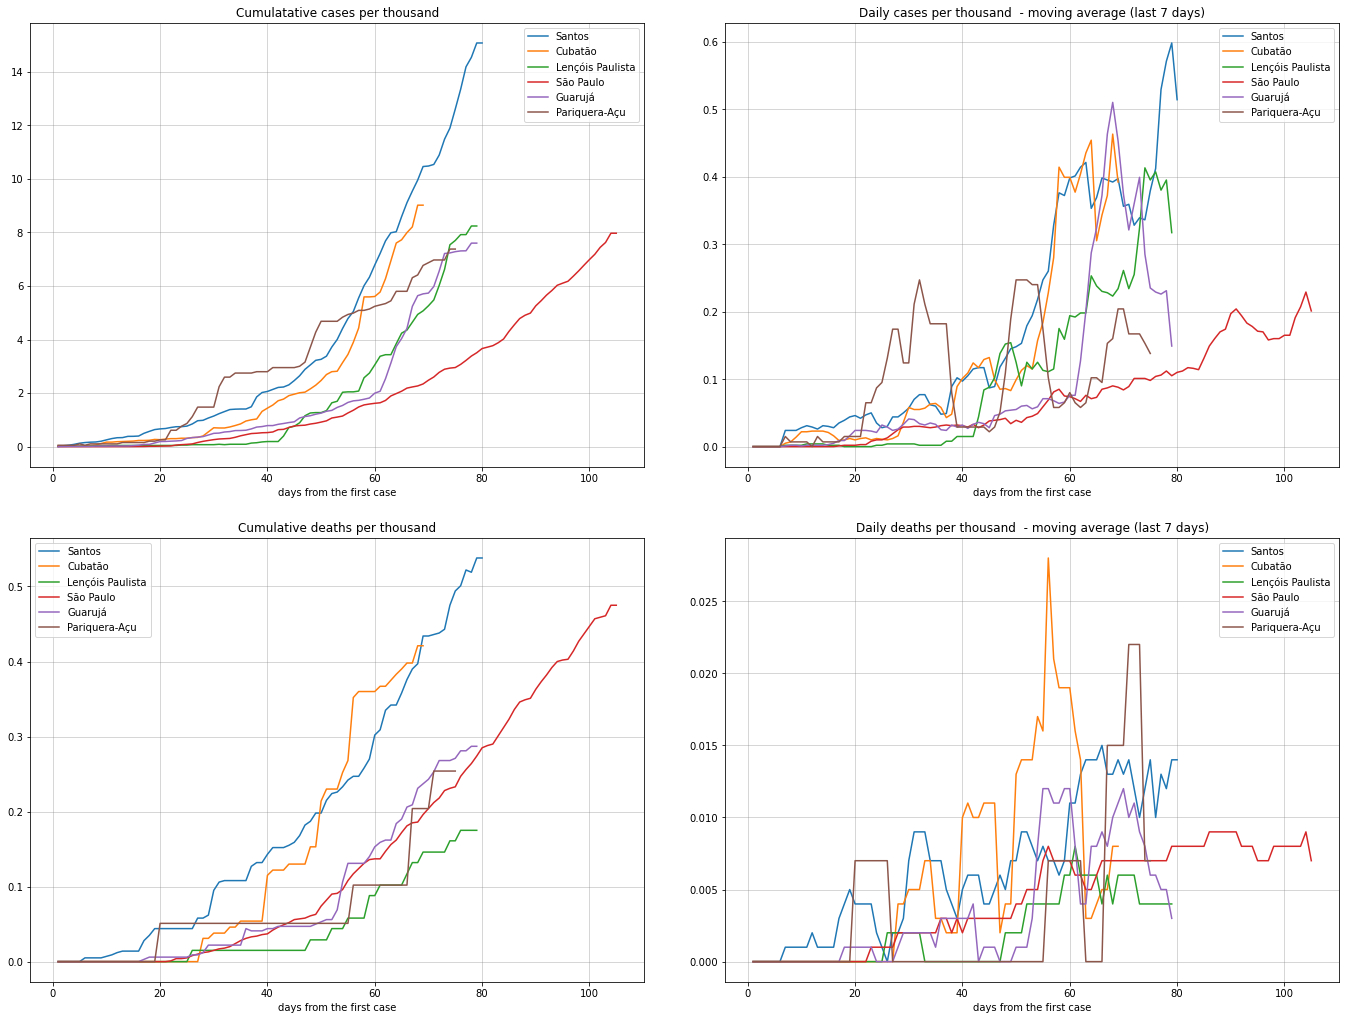

In [12]:
# Top most transmissible - SP
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases per thousand")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases per thousand  - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths per thousand")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths per thousand  - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)

for city in monitoredCities:
    dados = df[(df['city'] == city)]
    ax1.plot(dados.day, dados.cases_thousand, label = city)
    ax2.plot(dados.day, dados.avg7_case_day_thousand, label = city)
    ax3.plot(dados.day, dados.deaths_thousand, label = city)
    ax4.plot(dados.day, dados.avg7_death_day_thousand, label = city)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
fig.savefig('../analysis/saoPaulo_cities_cases_deaths.png')

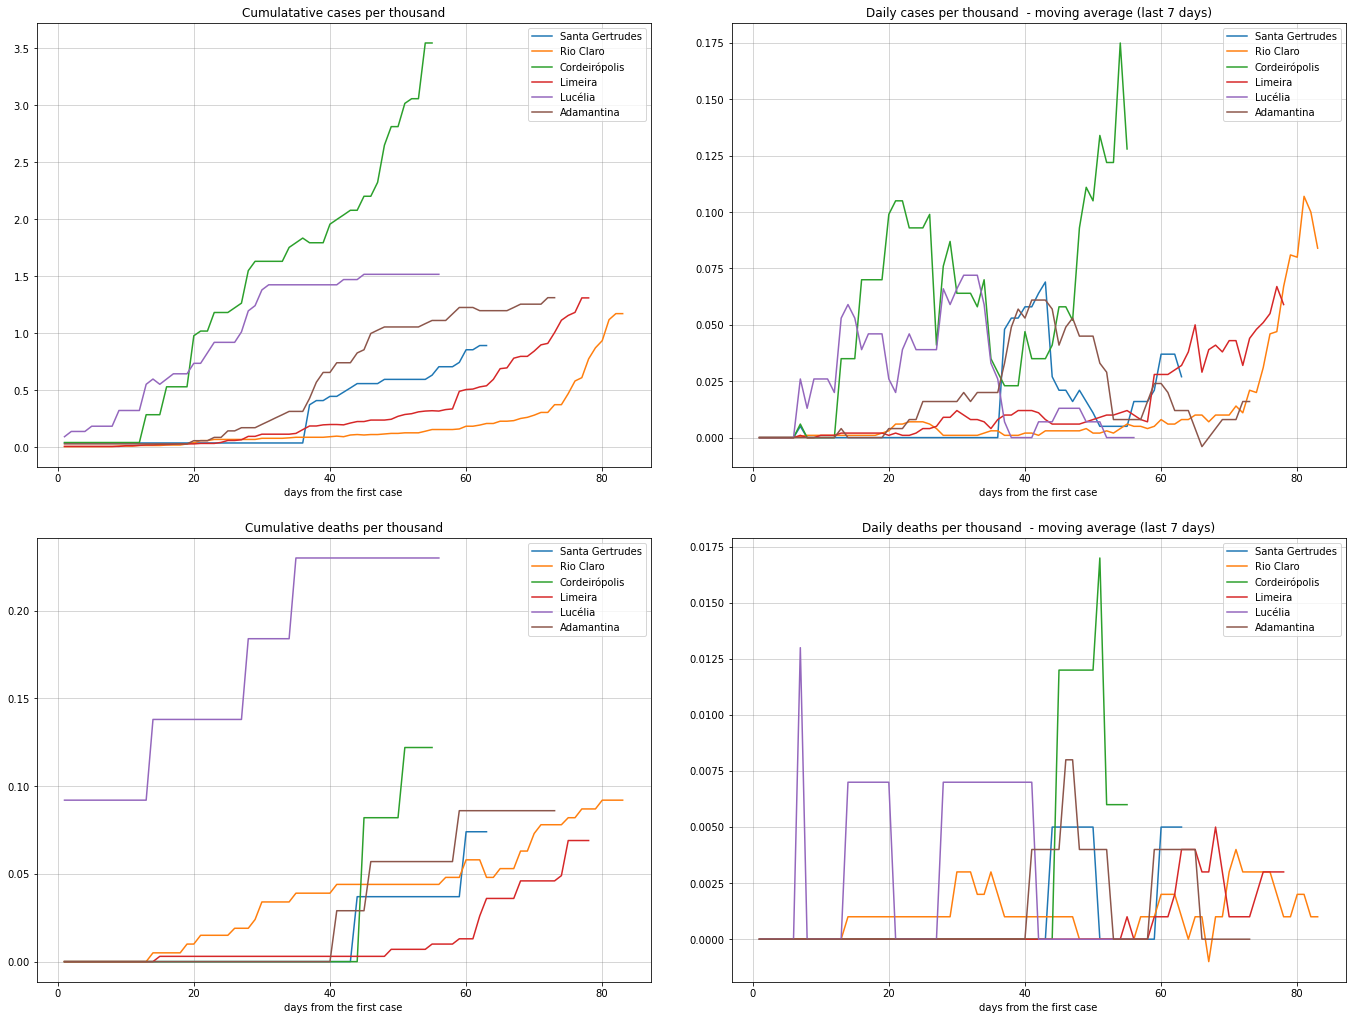

In [13]:
# Selected cities
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases per thousand")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases per thousand  - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths per thousand")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths per thousand  - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

for city in addedCities:
    dados = df[(df['city'] == city)]
    ax1.plot(dados.day, dados.cases_thousand, label = city)
    ax2.plot(dados.day, dados.avg7_case_day_thousand, label = city)
    ax3.plot(dados.day, dados.deaths_thousand, label = city)
    ax4.plot(dados.day, dados.avg7_death_day_thousand, label = city)
#     ax1.plot(df[df['country'] == country].day, df[df['country'] == country].cases, label = country)
#     ax2.plot(df[df['country'] == country].day, df[df['country'] == country].deaths, label = country)
#     ax3.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_cases, label = country)
#     ax4.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_deaths, label = country)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/saoPaulo_selectedCities_cases_deaths.png')

### Generating the html file

In [14]:
f = open('../html/saoPaulo_analysis.html', 'w')
f1 = open('../html/templates/saoPaulo_analysis_01.html', 'r').read()
f2 = open('../html/templates/saoPaulo_analysis_02.html', 'r').read()
f3 = open('../html/templates/saoPaulo_analysis_03.html', 'r').read()

readme = f1
readme += '          <p>Indicadores relativos aos dados da pandemia Covid19 no estado de São Paulo até a data de <strong>' + today.strftime("%d/%m/%Y") + '</strong>.</p>'
readme += '          <p style="font-size:14px"><i>Estas informações são para uso próprio e não devem ser utilizadas para direcionamentos médicos e/ou políticas públicas.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Análise semanal</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variação </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">casos</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' ('+str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">mortes</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: center;" width="25%">cidades contaminadas</td>'
readme += '      <td>'+str(lastWeekCities)+' ('+str(lastWeekPercCities)+'%)</td>'
readme += '      <td>'+str(todayCities)+' ('+str(todayPercCities)+'%)</td>'
readme += '      <td>'+str(diffCities)+ ' ('+str(varCities)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' cidades mais mortais do estado de São Paulo</h3>'
readme += '          <p><i>Mais: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>O ranking é feito a partir da quantidade total de mortes por cada mil habitantes de cada cidade do estado.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
# readme += df_top_deaths.style.set_properties(**{'font-size': '12pt','border-collapse': 'collapse','border': '1px solid black'}).render()
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' cidades mais transmissíveis do estado de São Paulo</h3>'
readme += '          <p><i>Mais: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>O ranking é feito a partir da quantidade total de casos por cada mil habitantes de cada cidade do estado.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

###########################################

f = open('../html/saoPaulo_analysis_EN.html', 'w')
f1 = open('../html/templates/saoPaulo_analysis_EN_01.html', 'r').read()
f2 = open('../html/templates/saoPaulo_analysis_EN_02.html', 'r').read()
f3 = open('../html/templates/saoPaulo_analysis_EN_03.html', 'r').read()

readme = f1
readme += '<p>These indicators are related to state of San Paulo Convid19 pandemic data up to <strong>' + today.strftime("%d/%m/%Y") + '</strong>.</p>'
readme += '             <p style="font-size:14px"><i>This information is for own use only and shall NOT be used for medical and public policy guidances.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Weekly analysis</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variations </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">cases</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' ('+str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">deaths</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: center;" width="25%">contaminated cities</td>'
readme += '      <td>'+str(lastWeekCities)+' ('+str(lastWeekPercCities)+'%)</td>'
readme += '      <td>'+str(todayCities)+' ('+str(todayPercCities)+'%)</td>'
readme += '      <td>'+str(diffCities)+ ' ('+str(varCities)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' deadliest cities of Sao Paulo</h3>'
readme += '          <p><i>Plus: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>This ranking is made from the total of deaths per each thousand of population of each city of the state.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' most transmissible cities of Sao Paulo</h3>'
readme += '          <p><i>Plus: ' + str(', '.join(addedCities)).title() + '</i></p>'
readme += '          <p>This ranking is made from the total of cases per each thousand of population of each city of the state.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

print('Sao Paulo\'s analysis done!')


Sao Paulo's analysis done!


In [15]:
# df[df['state']=='SP'][['date','death_day']]